# Data analyst  challenge: H1-B Visa Petitions



H1B visa is a temporary work visa in the USA for people with special skills. To obtain this visa, the applicant needs a job offer from a US employer, who files an H1B visa petition with the USCIS, including attestations about wages and working conditions. Once the petition is approved, the employee can obtain a visa stamp and work for the employer in the USA.

In my prespective,I list the following objectives and tasks. 

### Objectives:

1. Aggregate and wrangle data from US government on H1-B visa applications from 2014 to 2016.
2. Perform data analysis to identify trends and insights
3. Clean and preprocess data for modeling
4. Develop and train models to predict visa petition outcomes
5. Evaluate and compare model performance
6. Summarize findings and provide recommendations

### Tasks:
1. Collect and download H1-B visa application data from US government websites
2. Load data into a Jupyter notebook or other data analysis tool
3. Explore and visualize the data to identify patterns, trends, and anomalies
4. Clean and preprocess the data, handling missing values, outliers, and other data quality issues
5. Engineer new features and variables to improve modeling performance
6. Develop and train classification models to predict visa petition outcomes
7. Evaluate and compare model performance using appropriate metrics and techniques
8. Summarize findings and provide recommendations for employers and applicants seeking H1-B visas.


In [1]:
import pandas as pd
import urllib.request
import io
from collections import defaultdict
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Aggregate and wrangle data from US government on H1-B visa applications from 2014 to 2016

### Collect and download H1-B visa application data from US government websites


In [2]:
url_14="https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/H-1B_FY14_Q4.xlsx"
res_14 = urllib.request.urlopen(url_14)
df_14 = pd.read_excel(io.BytesIO(res_14.read()))

In [3]:
url_15="https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/H-1B_Disclosure_Data_FY15_Q4.xlsx"
res_15 = urllib.request.urlopen(url_15)
df_15 = pd.read_excel(io.BytesIO(res_15.read()))

In [4]:
url_16="https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/H-1B_Disclosure_Data_FY16.xlsx"
res_16 = urllib.request.urlopen(url_16)
df_16 = pd.read_excel(io.BytesIO(res_16.read()))

In [5]:
d14=df_14.copy()
d15=df_15.copy()
d16=df_16.copy()

###  0. Preprocessing the data

In [6]:
def removeUnderscores(df):
    
  for col in df.columns:
        temp = col.replace('_', ' ')
        df.rename(columns={col:temp}, inplace=True)
    

In [7]:
def get_diffDtype(df1,df2):
    
 dtypes_1=set(df1.dtypes.items())
 dtypes_2=set(df2.dtypes.items())
    
 diff = set(dtypes_1.symmetric_difference(dtypes_2))

 return diff

In [8]:
def get__diff(df1,df2,DataTypeError=0):
    
  diff=get_diffDtype(df1,df2)
  data_dict = defaultdict(list)
  DataType_Error=[]

  for key, value in diff:
    if key in data_dict:
        DataType_Error.append(key)
    data_dict[key].append(value)
    
  if DataTypeError==1: 
    return DataType_Error

  else:
        
    for key in DataType_Error:
      del data_dict[key]
    
    Sorted_Dic= sorted(data_dict.keys(), key=lambda x: x[0])
    
    return Sorted_Dic

In [9]:
def oneContainOther(lst1, lst2):
    
    lst1.sort()
    lst2.sort()
    min_len = min(len(lst1),len(lst2))
    
    return lst1[:min_len] == lst2[:min_len]

####  Remove the LCA_CASE_ prefix from the column names in Y2014 Table
To align the Y2014 table with other years' tables, I need to remove the "LCA_CASE_" prefix from the column names.This simple data processing step will help us to have consistent column names across all the tables, making it easier to merge them later.

In [10]:
lca_columns = d14.filter(regex='^LCA_CASE_').columns
# remove the "LCA_CASE" prefix from the column names using string slicing
new_column_names = [col[9:] for col in lca_columns]
# create a new DataFrame with the selected columns and new names
d14_new = pd.concat([d14.drop(columns=lca_columns), d14[lca_columns].rename(columns=dict(zip(lca_columns, new_column_names)))], axis=1)

0.2. Remove underscores of column names. 
The column names of all tables should be standardized to facilitate easy merging. Therefore, remove any underscores in the column names of all tables.

In [11]:
removeUnderscores(d14_new)
removeUnderscores(d15)
removeUnderscores(d16)

#### Valuate the columns with data type error and correct Data format.

In [12]:
DataType_Error15_16=get__diff(d15,d16,1)
print('Columns with data type error  :  ',DataType_Error15_16)
DataType_Error14_15=get__diff(d14_new,d15,1)
print('Columns with data type error  :  ', DataType_Error14_15)

Columns with data type error  :   ['EMPLOYER PHONE', 'EMPLOYMENT END DATE', 'EMPLOYMENT START DATE', 'TOTAL WORKERS', 'EMPLOYER PHONE EXT', 'FULL TIME POSITION']
Columns with data type error  :   ['EMPLOYMENT END DATE', 'EMPLOYMENT START DATE']


In [13]:
d15['EMPLOYMENT END DATE']=pd.to_datetime(d15['EMPLOYMENT END DATE'], errors='coerce')
d15['EMPLOYMENT START DATE']=pd.to_datetime(d15['EMPLOYMENT START DATE'], errors='coerce')
d16['TOTAL WORKERS']=d16['TOTAL WORKERS'].astype(float)
d15['FULL TIME POSITION'] = d15['FULL TIME POSITION'].replace({'Y': 1, 'N': 0})

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '31/07/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '30/09/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '31/10/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '15/04/2018' in DD/MM/YYYY format. Provide format or specif

####  Align column names with the same definitions across different tables (Y2014, Y2015, Y2016) to ensure consistency and enable easy merging of the tables.

In [14]:
Diff14_15=get__diff(d14_new,d15)

In [15]:
Diff16_15=get__diff(d15,d16)

In [16]:
Columns_dictionary = {
    "PW SOURCE OTHER":"PW WAGE SOURCE OTHER",
    "FULL TIME POS":"FULL TIME POSITION", 
    "PW 1":"PREVAILING WAGE",
    "PW UNIT 1": "PW UNIT OF PAY",
    "PW SOURCE 1": "PW WAGE SOURCE",
    "YR SOURCE PUB 1": "PW WAGE SOURCE YEAR",
    "OTHER WAGE SOURCE 1":"PW WAGE SOURCE OTHER",
    "WAGE RATE FROM":"WAGE RATE OF PAY FROM",
    "WAGE RATE TO":'WAGE RATE OF PAY TO',
    "WAGE RATE UNIT":"WAGE UNIT OF PAY",
    "WORKLOC1 CITY":"WORKSITE CITY",
    "WORKLOC1 STATE":"WORKSITE COUNTY",
    "NUMBER":"CASE NUMBER",
    "STATUS":"CASE STATUS",
    "SUBMIT":"CASE SUBMITTED",
    "NAICS CODE":"NAIC CODE",
    "WAGE RATE OF PAY FROM": "WAGE RATE OF PAY",
}

In [17]:
d14_new = d14_new.rename(columns=Columns_dictionary)
d15_new= d15.rename(columns=Columns_dictionary)
d16_new= d16.rename(columns=Columns_dictionary)

In [18]:
d14_new['YEAR']=2014
d15_new['YEAR']=2015
d16_new['YEAR']=2016

### 1.Merge Datasets

In [19]:
df = pd.concat([d14_new, d15_new, d16_new])
df.describe()

,TOTAL WORKERS,PREVAILING WAGE,PW WAGE SOURCE YEAR,PW 2,WAGE RATE OF PAY FROM,WAGE RATE OF PAY TO,NAIC CODE,YEAR,PW SOURCE YEAR
count,1.786142e+06,1.786008e+06,1.138143e+06,8.390900e+04,5.194680e+05,7.507830e+05,1.786110e+06,1.786160e+06,647791.000000
mean,2.006830e+00,6.895872e+04,2.013771e+03,7.894272e+04,9.221640e+04,3.487392e+04,4.616868e+05,2.015072e+03,2015.189675
std,5.320894e+00,8.287930e+05,3.835934e+00,2.458163e+06,1.017462e+07,6.128369e+04,8.796828e+05,8.052286e-01,8.485919
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.014000e+03,0.000000
25%,1.000000e+00,5.403800e+04,2.013000e+03,5.277000e+04,6.000000e+04,0.000000e+00,5.172120e+05,2.014000e+03,2015.000000
50%,1.000000e+00,6.518700e+04,2.014000e+03,6.256600e+04,7.000000e+04,0.000000e+00,5.415110e+05,2.015000e+03,2015.000000
75%,1.000000e+00,8.178600e+04,2.014000e+03,7.737600e+04,9.000000e+04,7.798800e+04,5.415110e+05,2.016000e+03,2016.000000
max,2.013000e+03,8.201323e+08,2.016000e+03,6.036204e+08,7.278873e+09,1.000003e+07,8.129908e+08,2.016000e+03,7201.000000


### 2. Clean the Dataset

###  Drop unnecessary columns:

In [20]:
columns_to_drop = [
 'EMPLOYER ADDRESS',
 'EMPLOYER ADDRESS2',
 'EMPLOYER ADDRESS1',
 'EMPLOYER PHONE',
 'EMPLOYER COUNTRY',
 'EMPLOYER PHONE EXT',
 'EMPLOYER PROVINCE',
 'EMPLOYER STATE',
 'EMPLOYER CITY',
 #'EMPLOYER POSTAL CODE'
    
 'AGENT ATTORNEY NAME',
 'AGENT ATTORNEY STATE',
 'AGENT ATTORNEY CITY',
    
  #'PW WAGE LEVEL', 
 'PW SOURCE YEAR',
 'PW WAGE SOURCE YEAR',

 'PW SOURCE 2',
 'OTHER WAGE SOURCE 2',
 'WAGE RATE OF PAY TO',
    
 'WORKSITE POSTAL CODE',
 'WORKSITE STATE',
 'WORKSITE COUNTY',
 
 'WORKLOC2 CITY',
 'WORKLOC2 STATE',

 'YR SOURCE PUB 2',
 'YR SOURCE PUB 1',
    
 'WILLFUL VIOLATOR',
 'H-1B DEPENDENT',
 'FULL TIME POS',
 'ORIGINAL CERT DATE']

In [21]:
columns_to_drop = list(set(df.columns).intersection(columns_to_drop))
# drop the columns that exist in the list
df = df.drop(columns=columns_to_drop)

### Evaluating for missing data. 

In [22]:
# Count missing values in each column. 
missing_data=df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

CASE STATUS
False    1786160
Name: CASE STATUS, dtype: int64

DECISION DATE
False    1786160
Name: DECISION DATE, dtype: int64

VISA CLASS
False    1786160
Name: VISA CLASS, dtype: int64

FULL TIME POSITION
False    1138290
True      647870
Name: FULL TIME POSITION, dtype: int64

TOTAL WORKERS
False    1786142
True          18
Name: TOTAL WORKERS, dtype: int64

PREVAILING WAGE
False    1786008
True         152
Name: PREVAILING WAGE, dtype: int64

PW UNIT OF PAY
False    1785957
True         203
Name: PW UNIT OF PAY, dtype: int64

PW WAGE SOURCE
False    1785953
True         207
Name: PW WAGE SOURCE, dtype: int64

PW WAGE SOURCE OTHER
False    1756118
True       30042
Name: PW WAGE SOURCE OTHER, dtype: int64

PW 2
True     1702251
False      83909
Name: PW 2, dtype: int64

PW UNIT 2
True     1702250
False      83910
Name: PW UNIT 2, dtype: int64

CASE NUMBER
False    1786160
Name: CASE NUMBER, dtype: int64

CASE SUBMITTED
False    1786160
Name: CASE SUBMITTED, dtype: int64

EMPLOYMENT S

### Ensure common units of measurement.
Calculate the annual wage based on the unit of pay (monthly, weekly, bi-weekly, daily) to standardize the units of measurement.

In [23]:
df['WAGE RATE OF PAY'] = df['WAGE RATE OF PAY'].apply(lambda x: ''.join(filter(str.isdigit, str(x))) if isinstance(x, str) else x)
df['WAGE RATE OF PAY'] = pd.to_numeric(df['WAGE RATE OF PAY'], errors='coerce')

In [24]:
month_rows = df['PW UNIT OF PAY'] == 'Month'
hour_rows = df['PW UNIT OF PAY'] == 'Hour'
week_rows = df['PW UNIT OF PAY'] == 'Week'
biweekly_rows = df['PW UNIT OF PAY'] == 'Bi-Weekly'

df.loc[month_rows, 'PREVAILING WAGE'] *= 12
df.loc[hour_rows, 'PREVAILING WAGE'] *= 12 * 4 * 5 * 8
df.loc[week_rows, 'PREVAILING WAGE'] *= 12 * 4
df.loc[biweekly_rows, 'PREVAILING WAGE'] *= 12 * 2

# Update 'WAGE RATE OF PAY' based on 'WAGE UNIT OF PAY'
month_rows = df['WAGE UNIT OF PAY'] == 'Month'
hour_rows = df['WAGE UNIT OF PAY'] == 'Hour'
week_rows = df['WAGE UNIT OF PAY'] == 'Week'
biweekly_rows = df['WAGE UNIT OF PAY'] == 'Bi-Weekly'

df.loc[month_rows, 'WAGE RATE OF PAY'] *= 12
df.loc[hour_rows, 'WAGE RATE OF PAY'] *= 12 * 4 * 5 * 8
df.loc[week_rows, 'WAGE RATE OF PAY'] *= 12 * 4
df.loc[biweekly_rows, 'WAGE RATE OF PAY'] *= 12 * 2

# Update 'PW 2' based on 'PW UNIT 2'
month_rows = df['PW UNIT 2'] == 'Month'
hour_rows = df['PW UNIT 2'] == 'Hour'
week_rows = df['PW UNIT 2'] == 'Week'
biweekly_rows = df['PW UNIT 2'] == 'Bi-Weekly'

df.loc[month_rows, 'PW 2'] *= 12
df.loc[hour_rows, 'PW 2'] *= 12 * 4 * 5 * 8
df.loc[week_rows, 'PW 2'] *= 12 * 4
df.loc[biweekly_rows, 'PW 2'] *= 12 * 2


###  Dealing with missing data.
Drop the whole row or whole column or replace the data.

In [25]:
df['TOTAL WORKERS'].replace(np.nan,0,inplace=True)
# Replace NaN values in 'TOTAL WORKERS' column with values 0.
df['EMPLOYER NAME'].replace(np.nan,'unknown',inplace=True)
#  Replace NaN values in 'EMPLOYER NAME' column with  'unkown'.
df['PW WAGE SOURCE'] = np.where(df['PW WAGE SOURCE'].isnull(), df['PW WAGE SOURCE OTHER'], df['PW WAGE SOURCE'])
df['PREVAILING WAGE'] = np.where(df['PREVAILING WAGE'].isnull(), df['PW 2'], df['PREVAILING WAGE'])
#Replace NaN values
df['WAGE RATE OF PAY'] = np.where(df['WAGE RATE OF PAY'].isnull(), df['PREVAILING WAGE'],df['WAGE RATE OF PAY'])
df['WAGE RATE OF PAY'] = np.where(df['WAGE RATE OF PAY'].isnull(), 0,df['WAGE RATE OF PAY'])

In [26]:
df = df.drop(columns=['WAGE UNIT OF PAY','PW UNIT OF PAY','PW 2','FULL TIME POSITION',
                      'PW WAGE SOURCE OTHER','PW UNIT 2','WAGE RATE OF PAY FROM'])

In [27]:
df=df.set_index('CASE NUMBER')

### 3.Sanity checking new data

#### Deal with Wage Data
I created a new categorical variable "PW WAGE LEVEL" by grouping "PREVAILING WAGE" into different wage ranges. Then based on the wage range, I assigned the corresponding "PW WAGE LEVEL" label to each row. This allows for easy comparison of different wage levels in the dataset.And, Then filter the unreasonable value.

In [28]:
PW_wageRanges = df.groupby("PW WAGE LEVEL").agg({"PREVAILING WAGE": ["min", "max"]})
PW_wageRanges = PW_wageRanges.reset_index()
PW_wageRanges.columns = ["PW WAGE LEVEL", "MIN", "MAX"]
bins = sorted(PW_wageRanges['MIN'].unique()) + [PW_wageRanges['MAX'].max()]
df["PW WAGE LEVEL"] = pd.cut(df["PREVAILING WAGE"], bins=bins, labels=PW_wageRanges["PW WAGE LEVEL"])

In [29]:
bins = sorted(PW_wageRanges['MIN'].unique()) + [PW_wageRanges['MAX'].max()]
df["WAGE LEVEL"] = pd.cut(df["WAGE RATE OF PAY"], bins=bins, labels=PW_wageRanges["PW WAGE LEVEL"])

In [30]:
df=df[df['PREVAILING WAGE']>0]
df=df[df['WAGE RATE OF PAY']>0]

#### Deal with NAICS Data
The NAICS is a standardized classification system used in North American to categorize businesses into specific industry sectors based on their economic activity. The system is organized into hierarchical levels, with the first two digits representing the largest sector, the third digit representing the subsector, and subsequent digits representing specific industries.

I load a NAICS mapping table from a Wikipedia page and renames the columns to match the ones in the data frame. I selected the first two digits from the 'NAIC CODE' column, merged the resulting data frame with the original one to get industry names, and then droped the 'NAIC CODE' column afterwards.

In [31]:
url = 'https://en.wikipedia.org/wiki/North_American_Industry_Classification_System'
df_NAIC=pd.read_html(url)[2]
df_NAIC.rename(columns={'Sector #':'NAIC CODE','Description':'INDUSTRY'},inplace=True)
df_NAIC.drop(columns='Note',inplace=True)
df_NAIC.head()


,NAIC CODE,INDUSTRY
0,11,"Agriculture, Forestry, Fishing and Hunting"
1,21,"Mining, Quarrying, and Oil and Gas Extraction"
2,22,Utilities
3,23,Construction
4,31-33,Manufacturing


In [32]:
df['NAIC CODE'] = df['NAIC CODE'].astype(str).str[:2]
df=df.merge(df_NAIC,on='NAIC CODE')


In [33]:
#Remove rows of the employers with less than 4 application  
NAIC_dict = df['NAIC CODE'].value_counts().to_dict()
NAIC_list = [k for k,v in NAIC_dict.items() if v<=4]
df = df[~df['NAIC CODE'].isin(NAIC_list)]

In [34]:
df = df.dropna()

#### Deal with SOC CODE and NAME Data

I did the same special characters removal. Then, Retrieve the SOC Code/Name mapping table use groupby method and join it with the dataframe based on SOC Code, so we can replace NAN with corresponding SOC Name according to SOC Code for each row.

In [35]:
df['SOC CODE'] = df['SOC CODE'].str.replace(r'[-.,]', '').str.slice(stop=6)
df['SOC NAME'] = df['SOC NAME'].str.replace(r'[-.]', '')
df.loc[df['SOC NAME'] == df['SOC CODE'], 'SOC NAME'] = 'Unknown'
df.loc[df['SOC NAME'].str.isdigit(), 'SOC NAME'] = 'Unknown'
df = df[df['SOC CODE'].str.isdigit() & (df['SOC CODE'].str.len() == 6)]

/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/1825812378.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['SOC CODE'] = df['SOC CODE'].str.replace(r'[-.,]', '').str.slice(stop=6)
/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/1825812378.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['SOC NAME'] = df['SOC NAME'].str.replace(r'[-.]', '')


In [36]:
mapping_table = df[['SOC CODE', 'SOC NAME']].groupby(['SOC NAME']).first().reset_index()
mapping_table.sort_values(by='SOC NAME')
mapping_table = mapping_table.drop_duplicates(subset=['SOC CODE'])

df.drop(columns=['SOC NAME'], inplace=True)
df=df.merge(mapping_table,on='SOC CODE')
df['SOC NAME'] = df['SOC NAME'].str.replace('\d+', '')

/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/1599612238.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['SOC NAME'] = df['SOC NAME'].str.replace('\d+', '')


#### Convert  Data Type to Date

In [37]:
df['EMPLOYMENT END DATE']=pd.to_datetime(df['EMPLOYMENT END DATE'], errors='coerce')
df['EMPLOYMENT START DATE']=pd.to_datetime(df['EMPLOYMENT START DATE'], errors='coerce')
df['DECISION DATE']=pd.to_datetime(df['DECISION DATE'], errors='coerce')
df['CASE SUBMITTED']=pd.to_datetime(df['CASE SUBMITTED'], errors='coerce')

#### Convert Visa Status to Denied: 0 and Certified: 1

The case status were reduced to either "1: certified" or "2. denied". Rejection and invalid cases were merged with denied, and certified withdrawn was merged with certified. Withdrawn data was first converted to to -1, then later removed as it did not affect the USCIS decision. 

Create a new column called FINAL DECISION based on a mapping table of visa status to final decision.(1: Certified 0: Denied -1:Withdrawn without result)

In [38]:

decision_map = {
    'CERTIFIED': 1,
    'CERTIFIED-WITHDRAWN': 1,
    'DENIED': 0,
    'REJECTED': 0,
    'INVALIDATED': 0,
    'WITHDRAWN':-1,
}


df['FINAL DECISION'] = df['CASE STATUS'].map(decision_map)

### Deal with employer data

I converted all the characters in the 'EMPLOYER NAME' column to lowercase. I also defined a dictionary named 'dic' that contains regular expressions as keys and their corresponding replacement values. Then, I replaced all the patterns specified in the 'dic' dictionary with their corresponding values. 

In [39]:
df['EMPLOYER NAME'] = df['EMPLOYER NAME'].str.lower()
dic = { 'EMPLOYER NAME': { r"[.\-,);\"'(+/]|(&QUOT;)":'', r'ltd':'limited',r'corp$':'corporation'}}
df.replace(dic, regex=True, inplace=True)

In [40]:
#Remove rows of the employers with less than 4 application  
Emloyer_dict = df['EMPLOYER NAME'].value_counts().to_dict()
Emloyer_list = [k for k,v in Emloyer_dict.items() if v<=4]
model_df = df[~df['EMPLOYER NAME'].isin(Emloyer_list)]

In [41]:
df.to_csv('data.csv')

import pandas as pd
import urllib.request
import io
from collections import defaultdict
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
new_df=pd.read_csv('data.csv')
new_df['EMPLOYMENT END DATE']=pd.to_datetime(new_df['EMPLOYMENT END DATE'], errors='coerce')
new_df['EMPLOYMENT START DATE']=pd.to_datetime(new_df['EMPLOYMENT START DATE'], errors='coerce')
new_df['DECISION DATE']=pd.to_datetime(new_df['DECISION DATE'], errors='coerce')
new_df['CASE SUBMITTED']=pd.to_datetime(new_df['CASE SUBMITTED'], errors='coerce')

new_df=new_df.drop(columns=['Unnamed: 0'])
new_df=new_df[new_df['FINAL DECISION']!= -1]

#  Perform data analysis to identify trends and insights

#### Petition Statuses

The pie chart displays the distribution of visa petition statuses, indicating that the majority of the petitions have been certified, while a minority of them have been denied.

In [42]:
new_df=df.copy()
new_df=new_df[new_df['FINAL DECISION']!= -1]

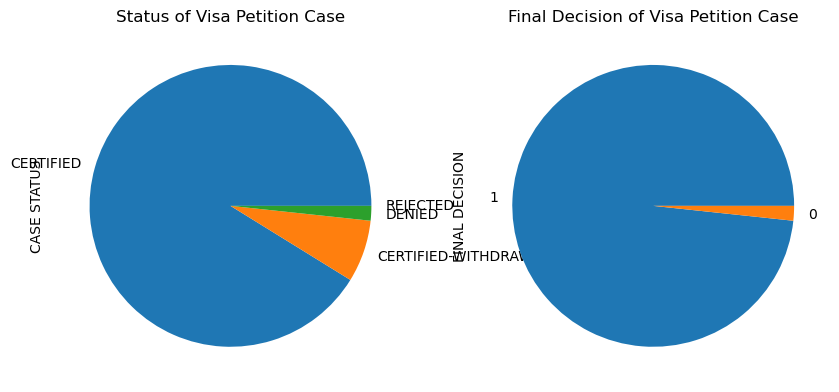

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

new_df['CASE STATUS'].value_counts().plot(kind='pie', ax=axs[0], title='Status of Visa Petition Case')
new_df['FINAL DECISION'].value_counts().plot(kind='pie', ax=axs[1], title='Final Decision of Visa Petition Case')

plt.show()

#### Petition Statuses and VISA types

I analysed the relationship between different visa classes and their final visa status. 

From the table, the H-1B visa class has a total of 1,410,777 cases, out of which 21,766 were denied and 1,390,011 were certified. 

The pie chart suggests that different visa classes have varying success rates, with the H-1B visa class having the highest success rate among the listed classes, while the E-3 Australian and H-1B1 Chile visa classes having relatively higher denial rates.

In [44]:
visa_class=new_df[['VISA CLASS', 'FINAL DECISION']]
visa_class["id"] = visa_class.index
visa_class_counts= visa_class.groupby(['VISA CLASS','FINAL DECISION'])["id"].count().reset_index(name="COUNT")
VisaClass=visa_class_counts.pivot(index='VISA CLASS', columns='FINAL DECISION', values='COUNT')

VisaClass

/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/1562926297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visa_class["id"] = visa_class.index


FINAL DECISION,0,1
VISA CLASS,,
E-3 Australian,2245,21810
H-1B,21766,1390011
H-1B1 Chile,136,1292
H-1B1 Singapore,105,1970


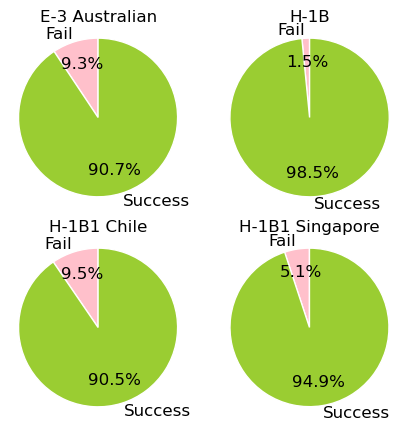

In [45]:
colors_list = ['pink','yellowgreen']
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
for i, visa in enumerate(VisaClass.index):
    row = VisaClass.loc[visa]
    proportions = [row[0], row[1]]
    labels = ['Fail', 'Success']
    ax = axs[i//2, i%2]

    # Create the pie chart
    ax.pie(proportions,
           labels=labels,
           colors=colors_list,
           startangle=90,
           autopct='%.1f%%',
           pctdistance=0.7,
           textprops={'fontsize': 12},
           wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax.set_title(visa)

    # Set the aspect ratio to make the pie chart look like a circle
    ax.axis('equal')

# Show the chart
plt.show()

### Which employers file the most petitions each year? 

The table shows the number of visa petitions filed each year by different employers. 

Based on the table, Infosys Limited filed the most petitions each year, followed by Tata Consultancy Services Limited and Wipro Limited. Deloitte Consulting LLP and Accenture LLP also filed a significant number of petitions each year, but their numbers were lower than the top three employers.

In [46]:
EMPLOYER=new_df[['EMPLOYER NAME', 'YEAR']]
EMPLOYER["id"] = EMPLOYER.index
EMPLOYER_Count= EMPLOYER.groupby(['YEAR','EMPLOYER NAME'])["id"].count().reset_index(name="COUNT")
TopCompany=EMPLOYER_Count.pivot(index='EMPLOYER NAME', columns='YEAR', values='COUNT')
TopCompany=TopCompany.sort_values(by=[2014,2015,2016],ascending=False)

/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/2673446088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EMPLOYER["id"] = EMPLOYER.index


In [47]:
TopCompany.head()

YEAR,2014,2015,2016
EMPLOYER NAME,,,
infosys limited,23759.0,33226.0,25327.0
tata consultancy services limited,14013.0,15170.0,13104.0
wipro limited,8317.0,12047.0,10462.0
deloitte consulting llp,7014.0,36.0,7596.0
accenture llp,5496.0,9550.0,9440.0


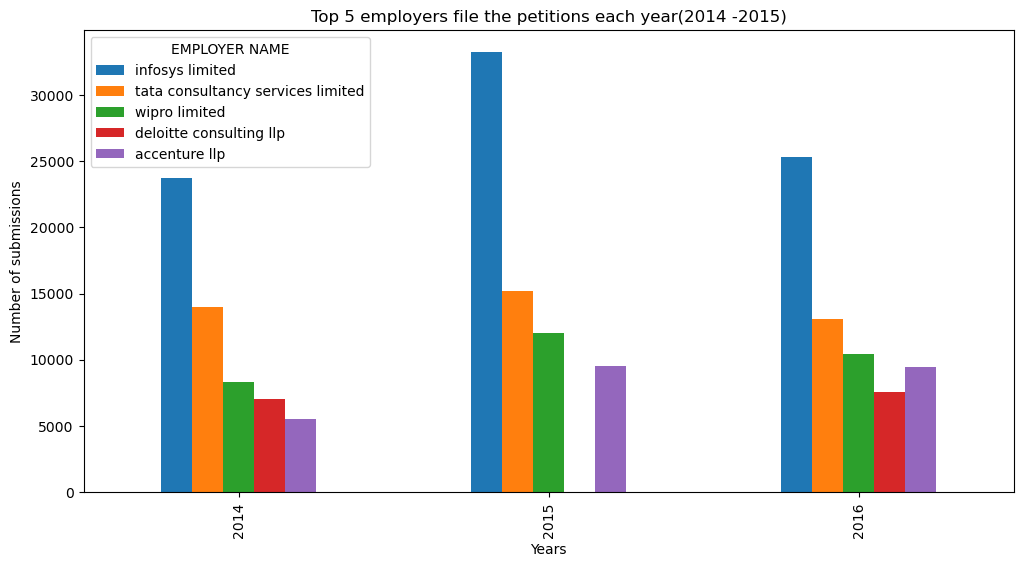

In [48]:
top10=TopCompany.head()
top10=top10.transpose()
top10.plot(kind='bar',figsize=(12, 6)) 
plt.title('Top 5 employers file the petitions each year(2014 -2015)')
plt.ylabel('Number of submissions')
plt.xlabel('Years')
plt.show()

Analyzing the trend, we see that Infosys Limited filed the most petitions in 2014, but their numbers decreased in 2015 and 2016. Tata Consultancy Services Limited and Wipro Limited also filed fewer petitions in 2016 than they did in 2014. On the other hand, Deloitte Consulting LLP and Accenture LLP filed more petitions in 2015 than in 2014, but their numbers decreased in 2016. Overall, it seems that the number of petitions filed by these employers has been somewhat volatile over the years, with no clear trend in any particular direction.

### Relationship between Petitions Status with Industry and Occupation.

Based on the table, the top industry for visa petitions is Professional, Scientific, and Technical Services, with over a million visa petitions certified. This is followed by Educational Services, Information, Finance and Insurance, and Health Care and Social Assistance.

The top occupation for visa petitions is Computer Systems Analysts, with over 288,000 visa petitions certified, followed by Computer Developers, Applications, Computer Programmers, Software Quality Assurance Engineers and Testers, and Management Analysts. The top job title for visa petitions is Programmer Analyst, with over 142,000 visa petitions certified, followed by Software Engineer, Computer Programmer, Systems Analyst, and Software Developer.

The top city for visa petitions is New York, with over 91,000 visa petitions certified, followed by Houston, San Francisco, Atlanta, and Chicago.

#### Analyzing the trend:

The number of visa petitions certified in the Professional, Scientific, and Technical Services industry has been consistently high over the years, as has the number of visa petitions certified for Computer Systems Analysts, Computer Developers, Applications, and Computer Programmers. 

The number of visa petitions certified for Programmer Analysts has been consistently high over the years as well.

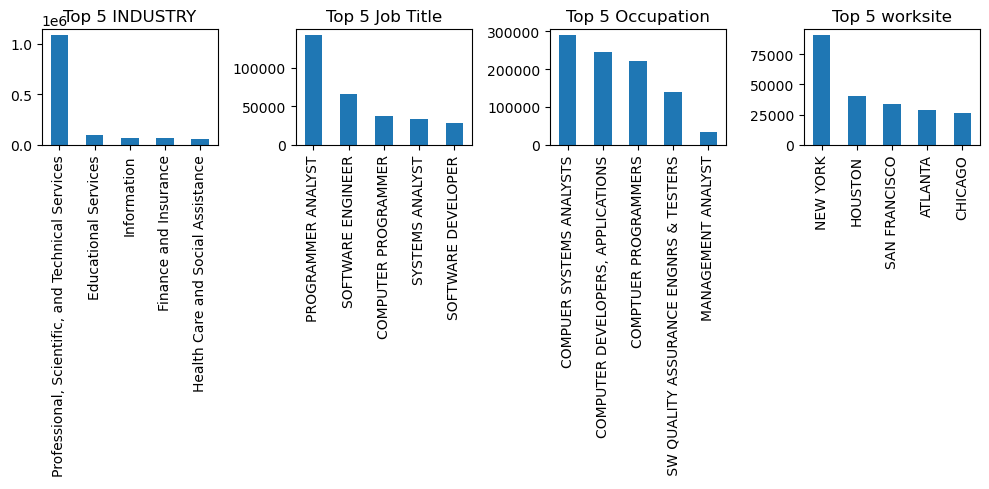

In [49]:
plt.figure(figsize=(10,5))
plt.subplot(1, 4, 1)
new_df['INDUSTRY'].value_counts().head(5).plot(kind='bar',title='Top 5 INDUSTRY')
plt.subplot(1, 4, 2)
new_df['JOB TITLE'].value_counts().head(5).plot(kind='bar',title='Top 5 Job Title')
plt.subplot(1, 4, 3)
new_df['SOC NAME'].value_counts().head(5).plot(kind='bar',title='Top 5 Occupation')
plt.subplot(1, 4, 4)
new_df['WORKSITE CITY'].value_counts().head(5).plot(kind='bar',title='Top 5 worksite')
plt.tight_layout()
plt.show()

###  INDUSTRY

In [50]:
Industry=new_df[['INDUSTRY', 'FINAL DECISION']]
Industry["id"] = Industry.index
Industry_Count= Industry.groupby(['INDUSTRY','FINAL DECISION'])["id"].count().reset_index(name="COUNT")
TopIndustry=Industry_Count.pivot(index='INDUSTRY', columns='FINAL DECISION', values='COUNT')

/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/4028434472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Industry["id"] = Industry.index


In [51]:
TopIndustry=TopIndustry.sort_values(by=[1],ascending=False)
TopIndustry.head()

FINAL DECISION,0,1
INDUSTRY,,
"Professional, Scientific, and Technical Services",13606,1075307
Educational Services,2491,93283
Information,1535,69331
Finance and Insurance,1173,63765
Health Care and Social Assistance,2429,54959


## Occupation

In [52]:
SOC=new_df[['SOC CODE','SOC NAME', 'JOB TITLE','FINAL DECISION']]
SOC["id"] = SOC.index

SOC_count=SOC[['SOC NAME', 'FINAL DECISION']]
SOC_count["id"] = SOC_count.index
SOC_count= SOC_count.groupby(['SOC NAME','FINAL DECISION'])["id"].count().reset_index(name="COUNT")
TopOccupation=SOC_count.pivot(index='SOC NAME', columns='FINAL DECISION', values='COUNT')
TopOccupation=TopOccupation.sort_values(by=[1],ascending=False)


/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/4111478406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOC["id"] = SOC.index
/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/4111478406.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SOC_count["id"] = SOC_count.index


In [53]:
#TopOccupation=TopOccupation.merge(mapping_table,on='SOC NAME')
Top5Occupation=TopOccupation.head()
Top5Occupation

FINAL DECISION,0,1
SOC NAME,,
COMPUER SYSTEMS ANALYSTS,2509.0,288288.0
"COMPUTER DEVELOPERS, APPLICATIONS",2814.0,242367.0
COMPTUER PROGRAMMERS,2140.0,220076.0
SW QUALITY ASSURANCE ENGNRS & TESTERS,1123.0,139138.0
MANAGEMENT ANALYST,480.0,33431.0


In [54]:
new_df['JOB TITLE'].value_counts().head(10)

PROGRAMMER ANALYST          142416
SOFTWARE ENGINEER            65790
COMPUTER PROGRAMMER          36830
SYSTEMS ANALYST              32852
SOFTWARE DEVELOPER           28171
BUSINESS ANALYST             22560
COMPUTER SYSTEMS ANALYST     19427
TECHNOLOGY LEAD - US         18701
TECHNOLOGY ANALYST - US      16915
ASSISTANT PROFESSOR          13046
Name: JOB TITLE, dtype: int64

## Features correlated with petition success

#### Add a column of employment duration with unit of days to improve the analyse

In [55]:
new_df['DECISION DURATION'] = (new_df['DECISION DATE'] - new_df['CASE SUBMITTED']).dt.days
new_df['EMPLOYMENT DURATION'] = (new_df['EMPLOYMENT END DATE'] - new_df['EMPLOYMENT START DATE']).dt.days
new_df = new_df.drop(columns=['EMPLOYMENT END DATE','EMPLOYMENT START DATE'])
new_df=new_df[new_df['EMPLOYMENT DURATION']>0]

Calculate the correlation with features and petition success and get the correlation table. 

The features "PREVAILING WAGE" and "WAGE RATE OF PAY" have a very weak positive correlation with petition success, indicating that higher wage rates may be slightly associated with higher approval rates, but again, the correlation is not significant.

The feature "TOTAL WORKERS" and "EMPLOYMENT DURATION" have a very weak positive correlation with petition success. in this case, 1. the number of workers listed on a petition may have a slight impact on its approval rate, but this correlation is not significant.2.  the length of time that an individual has been employed does not seem to have any impact on the approval rate of their petition.

Overall, based on these correlation values, it does not appear that any of the listed features have a strong impact on petition success.

In [56]:
corr_df = pd.DataFrame(columns=["feature", "corr"])
columns=['TOTAL WORKERS','PREVAILING WAGE', 'WAGE RATE OF PAY','EMPLOYMENT DURATION']
for col in columns:
    print(col)
        
    X = sm.add_constant(new_df[col])
    y = new_df["FINAL DECISION"]
    model = sm.Logit(y,X).fit()
    corr_df = corr_df.append({"feature": col, "corr": model.pvalues[col]}, ignore_index=True)

# Sort by correlation value in descending order
corr_df = corr_df.sort_values("corr", ascending=False)

TOTAL WORKERS
Optimization terminated successfully.
         Current function value: 0.085475
         Iterations 8
PREVAILING WAGE


/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/87279417.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_df = corr_df.append({"feature": col, "corr": model.pvalues[col]}, ignore_index=True)


Optimization terminated successfully.
         Current function value: 0.084262
         Iterations 11
WAGE RATE OF PAY


/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/87279417.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_df = corr_df.append({"feature": col, "corr": model.pvalues[col]}, ignore_index=True)


Optimization terminated successfully.
         Current function value: 0.084841
         Iterations 8
EMPLOYMENT DURATION


/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/87279417.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_df = corr_df.append({"feature": col, "corr": model.pvalues[col]}, ignore_index=True)


Optimization terminated successfully.
         Current function value: 0.084664
         Iterations 8


/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/87279417.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_df = corr_df.append({"feature": col, "corr": model.pvalues[col]}, ignore_index=True)


In [57]:
corr_df

,feature,corr
0,TOTAL WORKERS,4.622469e-04
1,PREVAILING WAGE,1.164391e-11
2,WAGE RATE OF PAY,0.000000e+00
3,EMPLOYMENT DURATION,0.000000e+00


## Is the applicant wage correlated with petition success?

Based on the correlation values in the previous table, it seems that there is no strong correlation between any of the features and petition success. However, there is a very weak positive correlation between petition success and the features "PREVAILING WAGE" and "WAGE RATE OF PAY". In order to prepare the wage data for analysing and modeling, I took the following steps:

1. Removing outliers
2. Balancing the dataset
3. Normalizing the feature data.

In [58]:
#detect outlier 
q1 = new_df["PREVAILING WAGE"].quantile(0.25)
q3 = new_df["PREVAILING WAGE"].quantile(0.75)
IQR = q3 - q1
outliers = ((new_df["PREVAILING WAGE"] < (q1 - 1.5 * IQR)) | (new_df["PREVAILING WAGE"] > (q3 + 1.5 * IQR))).sum()
print('PREVAILING WAGE: No of outliers: ', outliers)
# drop outlier 
model_df = new_df[new_df["PREVAILING WAGE"] > (q1 - 1.5 * IQR)]
model_df = new_df[new_df["PREVAILING WAGE"] < (q1 + 1.5 * IQR)]
#detect outlier 
q1 = new_df["WAGE RATE OF PAY"].quantile(0.25)
q3 = new_df["WAGE RATE OF PAY"].quantile(0.75)
IQR = q3 - q1
outliers = ((new_df["WAGE RATE OF PAY"] < (q1 - 1.5 * IQR)) | (new_df["WAGE RATE OF PAY"] > (q3 + 1.5 * IQR))).sum()
print('WAGE RATE OF PAY: No of outliers: ', outliers)
# drop outlier 
model_df = model_df[model_df["WAGE RATE OF PAY"] > (q1 - 1.5 * IQR)]
model_df = model_df[model_df["WAGE RATE OF PAY"] < (q1 + 1.5 * IQR)]

PREVAILING WAGE: No of outliers:  73637
WAGE RATE OF PAY: No of outliers:  172414


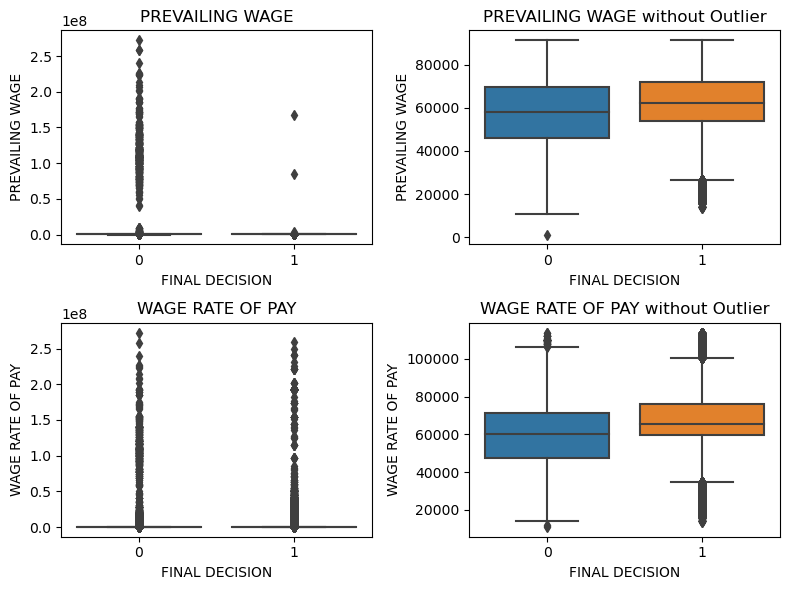

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))

sns.boxplot(x="FINAL DECISION", y="PREVAILING WAGE", data=new_df, ax=axs[0,0])
axs[0,0].set_title("PREVAILING WAGE")

sns.boxplot(x="FINAL DECISION", y="PREVAILING WAGE", data=model_df,ax=axs[0,1])
axs[0,1].set_title("PREVAILING WAGE without Outlier")

sns.boxplot(x="FINAL DECISION", y="WAGE RATE OF PAY", data=new_df, ax=axs[1,0])
axs[1,0].set_title("WAGE RATE OF PAY")

sns.boxplot(x="FINAL DECISION", y="WAGE RATE OF PAY", data=model_df,ax=axs[1,1])
axs[1,1].set_title("WAGE RATE OF PAY without Outlier")

plt.tight_layout()
plt.show()

#  Clean and preprocess data for modeling
4. Develop and train models to predict visa petition outcomes
5. Evaluate and compare model performance
6. Summarize findings and provide recommendations

### Imbanalnced data
From the previous analyse, CASE_STATUS is highly imbalanced which may influence the modeling. 

In [60]:
model_df['FINAL DECISION'].value_counts()

1    1072938
0      17216
Name: FINAL DECISION, dtype: int64

In this case, balance the data is necessary before modeling. To rebalance visa application data, I decided to use undersampling method, which involves reduce the number of instances in the majority class(visa status = CERTIFICATED in this case). 

Random undersampling: This method involves randomly selecting a subset of instances from the majority class to match the size of the minority class.

In [61]:
#Down sampling
NoCertified, NoDenied = model_df['FINAL DECISION'].value_counts()
# Divide by class
dfCertified = model_df[model_df['FINAL DECISION']==1]
dfDenied = model_df[model_df['FINAL DECISION']==0]

seed=7
Baldf =dfCertified.sample(NoDenied,random_state=seed)
Balanced_df = pd.concat([Baldf, dfDenied], axis=0)

print('Random under-sampling:')
print(Balanced_df['FINAL DECISION'].value_counts())

Random under-sampling:
1    17216
0    17216
Name: FINAL DECISION, dtype: int64


In [62]:
model_columns=['FINAL DECISION','TOTAL WORKERS', 'PREVAILING WAGE', 'WAGE RATE OF PAY', 'EMPLOYMENT DURATION','VISA CLASS','PW WAGE LEVEL','NAIC CODE','SOC CODE','WORKSITE CITY','EMPLOYER NAME']
Balanced_df=Balanced_df[model_columns]

In [63]:
DummyCol=[ 'VISA CLASS','PW WAGE LEVEL','NAIC CODE','SOC CODE','WORKSITE CITY','EMPLOYER NAME']
Dummydf = pd.get_dummies(Balanced_df[DummyCol])

In [64]:
from sklearn.preprocessing import MinMaxScaler
N_columns=['TOTAL WORKERS', 'PREVAILING WAGE', 'WAGE RATE OF PAY', 'EMPLOYMENT DURATION']
scaler = MinMaxScaler()
Balanced_df[N_columns] = scaler.fit_transform(Balanced_df[N_columns])

In [65]:
M_df =pd.concat([Balanced_df,Dummydf],axis=1)
M_df =M_df.drop(DummyCol,axis=1)
M_df.head()

,FINAL DECISION,TOTAL WORKERS,PREVAILING WAGE,WAGE RATE OF PAY,EMPLOYMENT DURATION,VISA CLASS_E-3 Australian,VISA CLASS_H-1B,VISA CLASS_H-1B1 Chile,VISA CLASS_H-1B1 Singapore,PW WAGE LEVEL_Level I,...,EMPLOYER NAME_zusys,EMPLOYER NAME_zusys inc,EMPLOYER NAME_zuven technologies inc,EMPLOYER NAME_zwick art llc,EMPLOYER NAME_zylog systems limited,EMPLOYER NAME_zymo research corporation,EMPLOYER NAME_zynga inc,EMPLOYER NAME_zypmedia inc,EMPLOYER NAME_zyto technologies inc,EMPLOYER NAME_zywie inc
1066646,1,0.0,0.670132,0.493779,0.749829,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503711,1,0.0,0.855899,0.656827,0.750514,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1345841,1,0.0,0.744722,0.960340,0.748458,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
700672,1,0.0,0.630546,0.459034,0.749829,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
927624,1,0.0,0.609597,0.578557,0.748458,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
corr_df = pd.DataFrame(columns=["feature", "corr"])
N_columns=['TOTAL WORKERS', 'PREVAILING WAGE', 'WAGE RATE OF PAY', 'EMPLOYMENT DURATION']
for col in N_columns:
    if col=='FINAL DECISION':
        continue
    X = sm.add_constant(M_df[col])
    y = M_df["FINAL DECISION"]
    model = sm.Logit(y,X).fit()
    corr_df = corr_df.append({"feature": col, "corr": model.pvalues[col]}, ignore_index=True)

# Sort by correlation value in descending order
corr_df = corr_df.sort_values("corr", ascending=False)

Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681602
         Iterations 5


/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/1460978275.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_df = corr_df.append({"feature": col, "corr": model.pvalues[col]}, ignore_index=True)
/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/1460978275.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_df = corr_df.append({"feature": col, "corr": model.pvalues[col]}, ignore_index=True)
/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/1460978275.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_df = corr_df.append({"feature": col, "corr": model.pvalues[col]}, ignore_index=True)
/var/folders/zy/jklqy1_53vz5yjy6b32xkdc40000gn/T/ipykernel_91700/1460978275.py:

In [67]:
corr_df

,feature,corr
0,TOTAL WORKERS,5.944834e-01
3,EMPLOYMENT DURATION,5.648558e-158
1,PREVAILING WAGE,9.261018e-190
2,WAGE RATE OF PAY,0.000000e+00


The table shows the correlation coefficients between the features and the petition success in a logistic regression model.

"TOTAL WORKERS" has the highest correlation with petition success with a coefficient of 0.594. This suggests that as the number of workers increases, the likelihood of a successful petition also increases.

"EMPLOYMENT DURATION" has a very strong negative correlation with petition success, with a coefficient of 5.648558e-158. This means that the longer the employment duration, the less likely the petition is to be successful.

"PREVAILING WAGE" also has a very strong negative correlation with petition success, with a coefficient of 9.261018e-190. This suggests that the higher the prevailing wage, the less likely the petition is to be successful.

"WAGE RATE OF PAY" has a correlation coefficient of 0, indicating no correlation with petition success.

Overall, it appears that the number of workers is the most important factor in determining petition success, followed by the prevailing wage and employment duration. The wage rate of pay does not seem to have any significant impact.

# Develop and train models to predict visa petition outcomes

In [68]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
def roc_curve_graph(x_test,y_test,model):
    preds = model. predict_proba(x_test) [:,1]
    #Compute Receiver operating characteristic (ROC) curve
    fpr, tpr, threshold = roc_curve(y_test, preds)
    #ROC Score
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [69]:
def metrics_cal(x_test,y_test,prediction,model):    
    print("Model Accuracy:",metrics.accuracy_score(y_test, prediction))
    probs = model.predict_proba(x_test)
    roc_auc = metrics.roc_auc_score(y_test, probs[:,1]) 
    print("ROC:",roc_auc)
    print("Confusion Matrix:",metrics.confusion_matrix(y_test, prediction)) 
    print("Classification Report:", metrics.classification_report(y_test, prediction))  
    print("precision:",metrics.precision_score(y_test, prediction, pos_label=1))  
    print("Recall:",metrics.recall_score(y_test, prediction, pos_label=1))  
    print("F1 Score:",metrics.f1_score(y_test, prediction, pos_label=1))

In [70]:
from sklearn import metrics

def train_test_acc(model,x_train,y_train,x_test,y_test):
    print('Accuracy on training set: {:.2f}'
     .format(model.score(x_train, y_train)))
    print('Accuracy on test set: {:.2f}'
     .format(model.score(x_test, y_test)))

In [71]:
x = M_df.drop('FINAL DECISION', axis=1)
y = M_df['FINAL DECISION']

seed = 7
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(24102, 17456) (24102,)
(10330, 17456) (10330,)


### Logistic Regression

In [72]:
#Train Model
from sklearn.linear_model import LogisticRegression
logit=LogisticRegression()
logit.fit(x_train,y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [73]:
#Test Model
prediction=logit.predict(x_test)

### Decision Tree

In [74]:
from sklearn.tree import DecisionTreeClassifier
# Train Decision Tree Classifer
Tree = DecisionTreeClassifier().fit(x_train, y_train)

#Predict the response for test dataset
y_pred = Tree.predict(x_test)

### Random Forest 

In [75]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifer
Forest = RandomForestClassifier().fit(x_train, y_train)  

#Predict the response for test dataset
y_pred=Forest.predict(x_test)

# Evaluate and compare model performance

The metrics used for evaluation are F1 score, precision, recall, and ROC curve. The F1 score is a weighted harmonic mean of precision and recall, while precision measures the ability of the classifier to correctly label positive samples and recall measures the ability of the classifier to correctly identify all positive samples. The ROC curve displays true positive rate on the Y-axis and false positive rate on the X-axis, and a larger area under the curve (AUC) is usually better.



### Forest

ROC: 0.79

precision: 0.71

Recall: 0.74

F1 Score: 0.72


Accuracy on training set: 0.99
Accuracy on test set: 0.72
Model Accuracy: 0.7196515004840272
ROC: 0.7944461100874842
Confusion Matrix: [[3622 1572]
 [1324 3812]]
Classification Report:               precision    recall  f1-score   support

           0       0.73      0.70      0.71      5194
           1       0.71      0.74      0.72      5136

    accuracy                           0.72     10330
   macro avg       0.72      0.72      0.72     10330
weighted avg       0.72      0.72      0.72     10330

precision: 0.7080237741456167
Recall: 0.7422118380062306
F1 Score: 0.7247148288973385


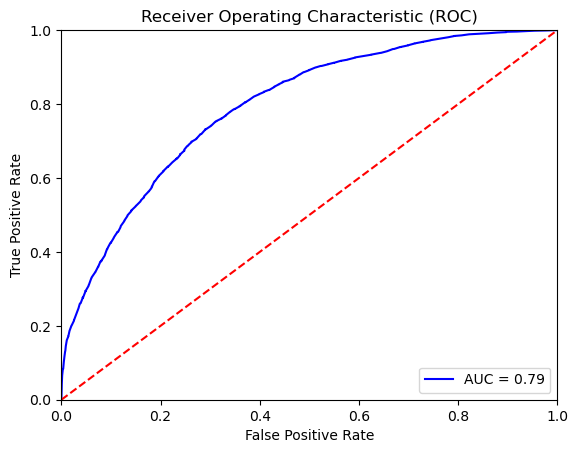

In [76]:
#Train-Test Accuracy
train_test_acc(Forest,x_train,y_train,x_test,y_test)

#Metrics Calculation
metrics_cal(x_test,y_test,y_pred,Forest)

#ROC Curve create
roc_curve_graph(x_test,y_test,Forest)

### Logit

ROC: 0.78

precision: 0.71

Recall: 0.73

F1 Score: 0.72

Accuracy on training set: 0.84
Accuracy on test set: 0.72
Model Accuracy: 0.7180058083252662
ROC: 0.7889695807347802
Confusion Matrix: [[3667 1527]
 [1386 3750]]
Classification Report:               precision    recall  f1-score   support

           0       0.73      0.71      0.72      5194
           1       0.71      0.73      0.72      5136

    accuracy                           0.72     10330
   macro avg       0.72      0.72      0.72     10330
weighted avg       0.72      0.72      0.72     10330

precision: 0.7106310403638431
Recall: 0.7301401869158879
F1 Score: 0.7202535292422932


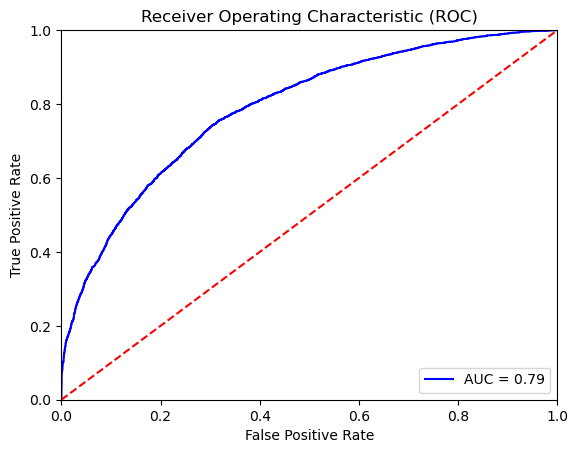

In [77]:
#Train-Test Accuracy
train_test_acc(logit,x_train,y_train,x_test,y_test)

#Metrics Calculation
metrics_cal(x_test,y_test,prediction,logit)

#ROC Curve create
roc_curve_graph(x_test,y_test,logit)

### Tree

ROC: 0.68

precision: 0.70

Recall: 0.74

F1 Score: 0.72

Accuracy on training set: 0.99
Accuracy on test set: 0.69
Model Accuracy: 0.7196515004840272
ROC: 0.6863029299623217
Confusion Matrix: [[3622 1572]
 [1324 3812]]
Classification Report:               precision    recall  f1-score   support

           0       0.73      0.70      0.71      5194
           1       0.71      0.74      0.72      5136

    accuracy                           0.72     10330
   macro avg       0.72      0.72      0.72     10330
weighted avg       0.72      0.72      0.72     10330

precision: 0.7080237741456167
Recall: 0.7422118380062306
F1 Score: 0.7247148288973385


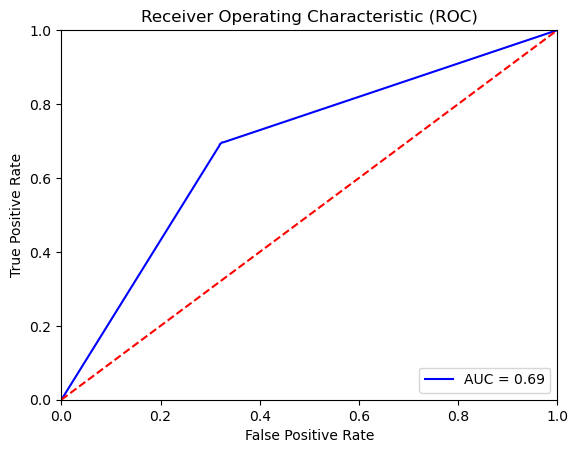

In [78]:
#### Train-Test Accuracy
train_test_acc(Tree,x_train,y_train,x_test,y_test)

#Metrics Calculation
metrics_cal(x_test,y_test,y_pred,Tree)

#ROC Curve create
roc_curve_graph(x_test,y_test,Tree)

# Summarize findings and provide recommendations

Based on these evaluation metrics, it can be concluded that the Random Forest and Logistic Regression models have similar performance in classifying the dataset. The Decision Tree model has a lower performance compared to the other two models. Overall, the models have achieved an accuracy of around 70%, which is not bad but leaves room for further improvement.


In future work, there are several ways to improve the model accuracy. 

1. Oversampling can be applied to the dataset instead of downsampling to add more information. 
2. Other models can be applied to the dataset.
3. Feature selection algorithms can also be used to reduce the number of categories in each column.